In [5]:
from pathlib import Path
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from tqdm.auto import tqdm
import pandas as pd
from pyspark.sql.types import StringType

tqdm.pandas()

# Initialize a Spark session
spark = SparkSession.builder.appName('DataAnalysis').getOrCreate()

# Define the function to read all sheets from an Excel file and convert to Spark DataFrame
def read_all_sheets_from_excel_spark(path: str) -> dict:
    all_sheets_spark = {}
    xls = pd.ExcelFile(path)
    for sheet_name in tqdm(xls.sheet_names, desc='Reading sheets'):
        # Read the sheet into a Pandas DataFrame
        pandas_df = xls.parse(sheet_name)
        
        # Convert the Pandas DataFrame to a Spark DataFrame
        spark_df = spark.createDataFrame(pandas_df)
        
        # Strip whitespace where possible from column names
        for c in spark_df.columns:
            new_col_name = c.strip() if isinstance(c, str) else c
            spark_df = spark_df.withColumnRenamed(c, new_col_name)
        
        # Strip whitespace where possible from cells
        for c in spark_df.columns:
            if isinstance(spark_df.schema[c].dataType, (StringType, StringType)):
                spark_df = spark_df.withColumn(c, col(c).cast("string").alias(c)).select("*")
        
        all_sheets_spark[sheet_name] = spark_df
    
    return all_sheets_spark

# Load the data into Spark DataFrames
file_path = Path('exim_hs_https___www.bps.go.id_exim_Kamis, 21 Desember 2023.xlsx')
dataframes_spark = read_all_sheets_from_excel_spark(file_path)

# Print each Spark DataFrame name and show the head of each Spark DataFrame
print('DataFrames in this file:', ', '.join(dataframes_spark.keys()))
for k, v in dataframes_spark.items():
    print('\n' + k + ' DataFrame head:')
    v.show()


Reading sheets:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


DataFrames in this file: Sheet1

Sheet1 DataFrame head:
+---------------------+------------------+-----------------+-----------------+----------------+
|Kode HS dan Deskripsi|Nilai Ekspor (USD)|Berat Ekspor (Kg)|Nilai Impor (USD)|Berat Impor (Kg)|
+---------------------+------------------+-----------------+-----------------+----------------+
|  [01] Binatang hidup|         339232.89|        15526.295|         25831747|         9280379|
|    [02] Daging hewan|       2344321.047|        244692.47|        100250079|        31994723|
| [03] Ikan, krusta...|   3.44887753056E8|   6.8593037886E7|         38513721|        17971235|
| [04] Susu, menteg...|    6.3179932897E7|      3193005.456|         97567270|        32939649|
|   [05] Produk hewani|       3832525.455|       2864544.73|          6405401|         5390118|
| [06] Pohon hidup ...|       1524806.215|       654228.321|          1236437|          177324|
|         [07] Sayuran|    1.4144264875E7|     1.64149504E7|         62330768|  

In [39]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns




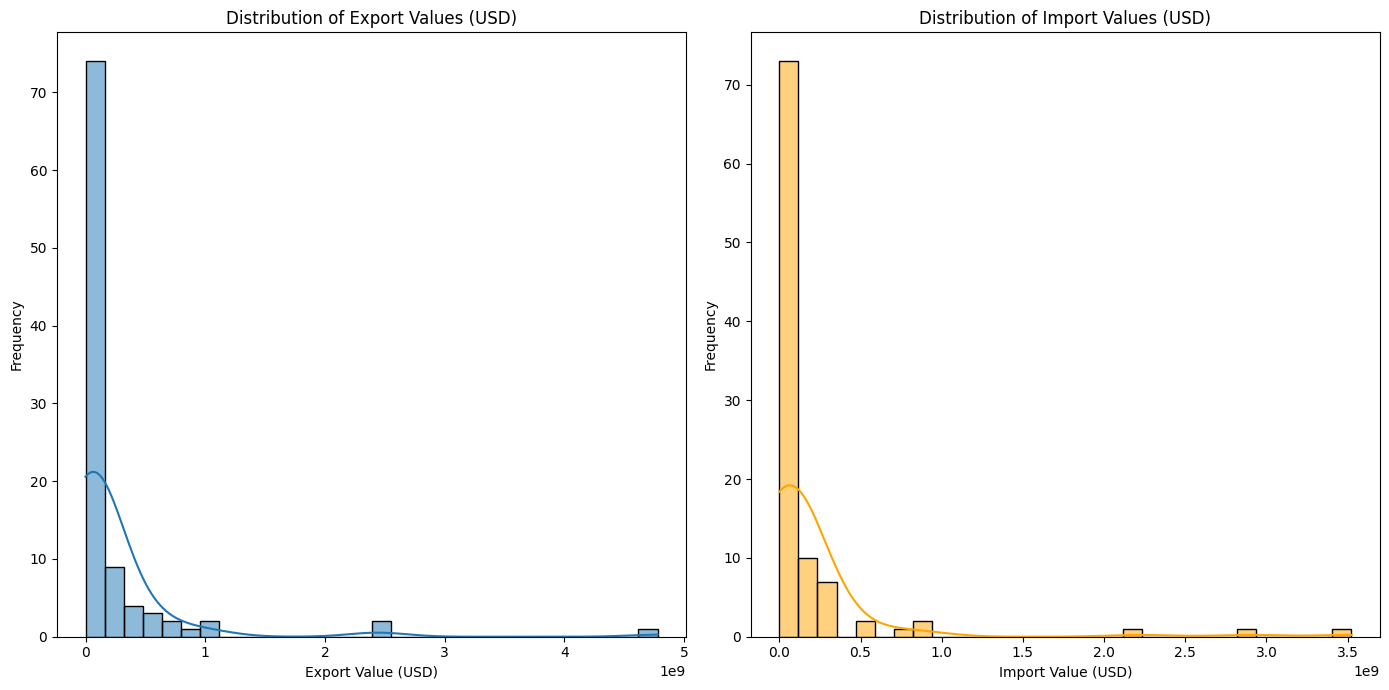

In [40]:
# Select the Spark DataFrame to visualize
sheet_name = 'Sheet1'
df_spark = dataframes_spark[sheet_name]

# Drop rows with any missing values to avoid errors during visualization
df_spark_clean = df_spark.na.drop()

# Convert columns to appropriate data types
df_spark_clean = df_spark_clean.withColumn('Nilai Ekspor (USD)', df_spark_clean['Nilai Ekspor (USD)'].cast('double'))
df_spark_clean = df_spark_clean.withColumn('Nilai Impor (USD)', df_spark_clean['Nilai Impor (USD)'].cast('double'))

# Convert Spark DataFrame to Pandas DataFrame for visualization
df_pandas_clean = df_spark_clean.toPandas()

# Plotting distributions of export and import values using Pandas and Seaborn
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(df_pandas_clean['Nilai Ekspor (USD)'], bins=30, kde=True)
plt.title('Distribution of Export Values (USD)')
plt.xlabel('Export Value (USD)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_pandas_clean['Nilai Impor (USD)'], bins=30, kde=True, color='orange')
plt.title('Distribution of Import Values (USD)')
plt.xlabel('Import Value (USD)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [41]:
# Since the histograms have been visualized, let's now look at the summary statistics for the export and import values.
summary_export = df_pandas_clean['Nilai Ekspor (USD)'].describe()
summary_import = df_pandas_clean['Nilai Impor (USD)'].describe()

print('Summary statistics for export values (USD):')
print(summary_export)
print('\nSummary statistics for import values (USD):')
print(summary_import)

Summary statistics for export values (USD):
count    9.800000e+01
mean     2.259869e+08
std      6.087176e+08
min      1.372971e+03
25%      5.841345e+06
50%      4.148230e+07
75%      1.568157e+08
max      4.779048e+09
Name: Nilai Ekspor (USD), dtype: float64

Summary statistics for import values (USD):
count    9.800000e+01
mean     1.905399e+08
std      5.163678e+08
min      6.959400e+04
25%      1.600875e+07
50%      4.912909e+07
75%      1.175338e+08
max      3.523420e+09
Name: Nilai Impor (USD), dtype: float64


In [42]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors

# Select the Spark DataFrame to analyze
sheet_name = 'Sheet1'
df_spark = dataframes_spark[sheet_name]

# Drop rows with any missing values to avoid errors during analysis
df_spark_clean = df_spark.na.drop()

# Convert columns to appropriate data types
df_spark_clean = df_spark_clean.withColumn('Nilai Ekspor (USD)', df_spark_clean['Nilai Ekspor (USD)'].cast('double'))
df_spark_clean = df_spark_clean.withColumn('Nilai Impor (USD)', df_spark_clean['Nilai Impor (USD)'].cast('double'))

# Create a feature vector
numeric_cols = [col_name for col_name, data_type in df_spark_clean.dtypes if data_type == 'double']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol='features')
df_spark_features = assembler.transform(df_spark_clean)

# Calculate the correlation matrix
correlation_matrix_spark = Correlation.corr(df_spark_features, 'features').head()

# Extract the correlation matrix as a NumPy array
correlation_matrix_array = correlation_matrix_spark[0].toArray()

# Display the correlation matrix
print('Correlation matrix (Spark DataFrame):')
print(correlation_matrix_array)


Correlation matrix (Spark DataFrame):
[[1.         0.79851059 0.68633404]
 [0.79851059 1.         0.66109533]
 [0.68633404 0.66109533 1.        ]]


In [54]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Selecting features and target variable
assembler = VectorAssembler(
    inputCols=['Berat Ekspor (Kg)', 'Berat Impor (Kg)'],
    outputCol='features'
)

df_spark_features = assembler.transform(df_spark_clean)

# Selecting the target variable
df_spark_features = df_spark_features.select('features', 'Nilai Ekspor (USD)')


In [56]:
from pyspark.ml.feature import StandardScaler

# Scaling the features
scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=True
)

scaler_model = scaler.fit(df_spark_features)
df_spark_scaled = scaler_model.transform(df_spark_features)

# Selecting the scaled features and target variable
df_spark_scaled = df_spark_scaled.select('scaled_features', 'Nilai Ekspor (USD)')


In [57]:
# Splitting the dataset into training and testing sets
train_data, test_data = df_spark_scaled.randomSplit([0.8, 0.2], seed=42)


In [58]:
from pyspark.ml.regression import LinearRegression

# Initializing the Linear Regression model
lr = LinearRegression(featuresCol='scaled_features', labelCol='Nilai Ekspor (USD)')

# Training the model
model = lr.fit(train_data)


In [59]:
# Predicting on the test set
predictions = model.transform(test_data)

# Calculating the performance metrics
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol='Nilai Ekspor (USD)', metricName='mse')
mse = evaluator.evaluate(predictions)

evaluator = RegressionEvaluator(labelCol='Nilai Ekspor (USD)', metricName='r2')
r2 = evaluator.evaluate(predictions)

print('Mean Squared Error:', mse)
print('R-squared:', r2)


Mean Squared Error: 2.6054455822819293e+17
R-squared: 0.09469517777638059


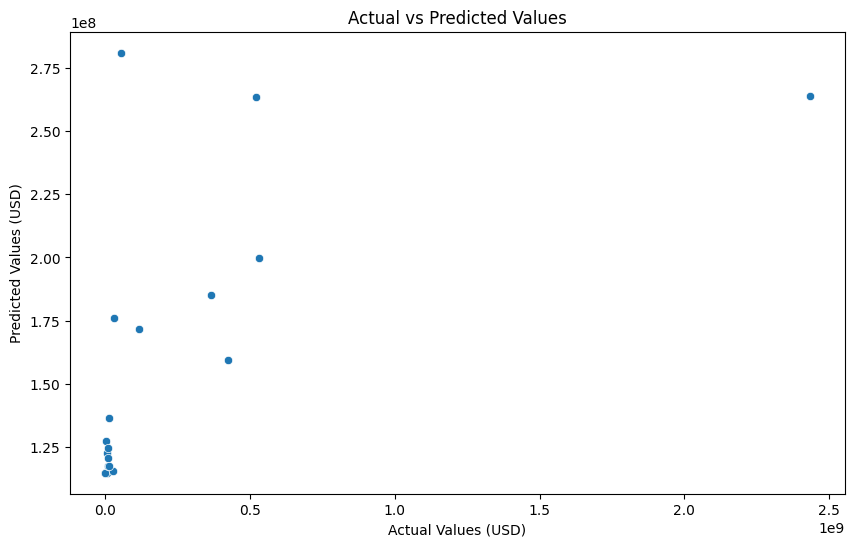

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the predictions to Pandas DataFrame for visualization
predictions_pd = predictions.select('Nilai Ekspor (USD)', 'prediction').toPandas()

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Nilai Ekspor (USD)', y='prediction', data=predictions_pd)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values (USD)')
plt.ylabel('Predicted Values (USD)')
plt.show()
